In [1]:
from IPython.display import Image
from PIL import Image  as pimg

##ChemicalX

Code Url : https://github.com/AstraZeneca/chemicalx

Paper Url: https://arxiv.org/pdf/2202.05240

Documentation: https://chemicalx.readthedocs.io/en/latest/

This notebook is a demonstration of a series of experiments for Drug-Drug Interaction, Polypharmacy and Drug Synergy capabilities of  the chemicalX library. Developed by AstraZeneca in 2022, this set of deep leaning models was created as an additional tool for Drug Safety Researchers, Computational Chemists and Oncologists to help solve drug combination synergy problems, polypharmacy side effects and drug-drug interactions with less reliance on physical lab tests.


The models in the library work by creating latent respresentations of drug molecule pairs, with preprocessed features and labels as input. In the case of drug  combination synegy, a third biological context input is used. Once each input of the Drug-Drug pair or Drug-Drug-Context triple is encoded into it's latent representation, it is passed into a <b>Head Layer</b> that outputs a scaler probability of a positive answer to the following questions, depending on the type of research:

• <b>Polypharmacy side effects.</b> Is it possible that drugs X and
Y together cause polypharmacy side effect Z?

• <b>Drug-drug interactions.</b> Can drugs X and Y have interaction Z when administered together?

• <b>Pair synergy identification.</b> Are drugs X and Y synergistic at treating disease Z when applied in combination.


A diagram of the encoder /head layer architecture is shown below:

<img src="https://raw.githubusercontent.com/AstraZeneca/chemicalx/main/images/pair_scoring.jpg">

***Image From <a href="https://github.com/AstraZeneca/chemicalx"> ChemicalX Github Repository</a>***

# Task Definitions:

##<b>Polypharmacy </b> - According to the National Library of Medicine, Polypharmacy occurs when 5 or more medicines are administered, increasing the risk of falls, fraility, disability and mortality. Other definitions consider just 2 drugs administered at the same time as polypharmacy.

##<b>Drug-Drug Interactions</b>: "A change in a drug’s effect on the body when the drug is taken together with a second drug. A drug-drug interaction can delay, decrease, or enhance absorption of either drug. This can decrease or increase the action of either or both drugs or cause adverse effects." *(National Institute of Health)*

##<b>Synergy</b> - "In medicine, describes the interaction of two or more drugs when their combined effect is greater than the sum of the effects seen when each drug is given alone." *(National Cancer Institute)*





#Installation

ChemicalX is based on torchdrug and Pytorch Goemetric. The accompanying libraries, including Torch Scatter will be needed.

Additional libraries will include:

molSimplify - A 3D rendering toolkit for molecules using SMILES as input.

py3Dmol     - Required for molSimplify.

rdkit       - A toolkit for rendering molecules in 2 and 3 dimensional space.

##Installation may take up to 30 minutes.


In [2]:
##Finding Pytorch Version
import torch
import numpy as np
import pandas as pd
import os
print(torch.__version__)
torch_version = f"{torch.__version__}"


2.2.1+cu121


In [3]:
## Install ChemicalX and rdkit to visualize molecules
! pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{torch_version}.html
! pip install torchdrug
! pip install chemicalx
! rdkit==2022.9.5
!pip install molSimplify
!pip install py3Dmol


Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html


In [4]:
import os
import rdkit
from rdkit import Chem

In [5]:
import datetime
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import time

from pathlib import Path
from google.colab import userdata

RANDOM_SEED = 1024
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)



## Loading Data

ChemicalX provides various proprocessed datasets from publicly available data  sources. Below is a list of the data sources with respective ChemicalX tasks.

 <h1>Dataset</h1> | <h1>ChemicalX Task</h1> | <h1>Url</h1>
--- | --- | ---
 <h3>**TWOSIDES**</h3> | <h3>**Polypharmacy**</h3> | <h3>https://tatonettilab.org/resources/tatonetti-stm.html</h3>
 <h3>**Drugbank**</h3> | <h3>**Drug-Drug Interaction** </h3>         | <h3>https://go.drugbank.com/</h3>
 <h3>**DrugComb**</h3> | <h3>**Synergy** </h3>     | <h3>https://drugcomb.fimm.fi/</h3>
 <h3>**DrugCombDB**</h3>  | <h3>**Synergy** </h3>  | <h3>http://drugcombdb.denglab.org/main</h3>
 <h3>**OncoPolyPharm**</h3> | <h3>**Synergy**</h3>   | <h3></h3>



#Potential ChemicalX compatibility issue!

  Depending on the version of TorchDrug, some users may run into the following error:

AttributeError: type object 'Molecule' has no attribute 'dummy_atom'. To resolve this issue, run the code below:


In [6]:
#Determine your Python location
!which python
!python --version

/usr/local/bin/python
Python 3.10.12


In [7]:
##Creat a variable, making sure to point to the constants.py file in the correct dist-packages folder as shown below :
chemicalX_constants_path = "/usr/local/lib/python3.10/dist-packages/chemicalx/constants.py"
os.environ['CX_PATH'] = chemicalX_constants_path

In [8]:
## Run this line to change the  TORCH_NODE_FEATURES variable in the the constants.py file
## This code is replaceing the  variable value for the TORCHDRUG_NODE_FEATURES from len(atom_default(Molecule.dummy_atom)) to 128.
## 128 was chosen based on the features used in the examples, but can be any appropriate integer.

!sed -i 's/TORCHDRUG_NODE_FEATURES = len(atom_default(Molecule.dummy_atom))/TORCHDRUG_NODE_FEATURES = 128/g' $CX_PATH

## Note: If this does not work, open the constants.py file directly and update the TORCHDRUG_NODE_FEATURES variable accordingly.

#Data Exploration:

Although the data is already preprocessed, users may want to further preprocess or validate it. There are several ways to access the data from the sources using the provided datasetloader module. The data provided here may not be up to date with the newest drugs, but users may add new data as needed.

In [268]:
## To get the features of any of the mentioned datasets:
from chemicalx.data.datasetloader import RemoteDatasetLoader
from rdkit.Chem import rdFingerprintGenerator , DataStructs , rdMolDescriptors, Draw, MolFromSmiles
from rdkit.Chem.rdMolDescriptors import GetHashedMorganFingerprint
from torchdrug.data import Molecule
from molSimplify.Informatics.jupyter_vis import view_structures
from molSimplify.Classes.mol3D import mol3D
## current list of data sources:
data_sources = ["drugcombdb", "drugcomb", "twosides", "drugbankddi"]

##  Expose some of the functions in the RemoteDatasetLoader to view get more access to the dataset.
class CustomRtDatasetLoader(RemoteDatasetLoader):
    def __init__(self, data_source: str):
      super().__init__(data_source)
      self.raw_data_url          = f"https://raw.githubusercontent.com/AstraZeneca/chemicalx/main/dataset/{data_source}/drug_set.json"
      self.raw_data_json         = self.load_raw_json_data(path = self.raw_data_url)
      self.rdkit_drug_mols  = []

    ## return rdkit 2D visualization of one molecule using the id
    def get_molecule_by_id (self, identifier: str):
      smiles = self.raw_data_json[identifier]['smiles']
      _molecule= MolFromSmiles(smiles)
      return {identifier : { "mol":_molecule, "smiles":smiles }}

    ## return rdkit 2D visualization of one molecule using the smiles
    def get_molecule_by_smiles (self, smiles: str):
      _molecule= MolFromSmiles(smiles)
      return {smiles : _molecule }

    ## create rdkit 2D visualizations of all the returned molecules and save as attribute
    def set_rdkit_drug_mols_by_id(self):
      print('..Generating Drug Molecule Visualizations')
      self.rdkit_drug_mols = [self.get_molecule_by_id(id) for id in list(self.raw_data_json.keys())]

    ## Morgan Fingerprints based on description in paper i.e.
    ## 256Bit Hashed Morgan Fingerprints with a Radius of 2
    def get_morgan_fingerprints(self, smiles, radius=2, nBits=256):
      m1  = MolFromSmiles(smiles)
      fp  = GetHashedMorganFingerprint(mol=m1, radius=radius, nBits=nBits)
      arr = np.zeros((0, ), dtype=np.int8)
      DataStructs.ConvertToNumpyArray(fp, arr)
      if isinstance(arr, np.ndarray):
        return torch.tensor(arr)
      return None

    def draw_rdkit_im(self, mols, legends , molsPerRow=2,  subImgSize= (500, 500) ):
      img=Draw.MolsToGridImage(mols,molsPerRow=molsPerRow,subImgSize=(500,500) , legends = legends)
      return img

    def view_in_3D(self, smiles, limit = 4):
        "View smiles in 3D with a limit"
        _mol0 = mol3D()
        _mol1 = mol3D()
        _mol2 = mol3D()
        _mol3 = mol3D()

        _mols = []
        for  idx, smile in enumerate(smiles[0:limit]):

          if idx == 0 :
            _mol0.read_smiles(smile)
            _mols.append(_mol0)

          elif idx == 1:
            _mol1.read_smiles(smile)
            _mols.append(_mol1)

          elif idx == 2:
            _mol2.read_smiles(smile)
            _mols.append(_mol2)

          elif idx == 3:
            _mol3.read_smiles(smile)
            _mols.append(_mol3)

        return view_structures(_mols)



##Features and Visualizations:

This section will show how to examine and visualize the data. Although the visualization libraries used here are not part of ChemicalX, they can assist in validating the data.


In [269]:
#View the preprocessed features of one compound as follows:
# This process will also retrieve every compound in the dataset and place it in a local json file.
drugbankddi_rds = CustomRtDatasetLoader("drugbankddi")
remote_drug_features = drugbankddi_rds.get_drug_features()
remote_drug_features['DB00998']

{'features': tensor([[0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 5., 0., 0., 0., 0., 2., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
          0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
    

In [270]:
## To get ALL the smiles and RdKit molecules for the downloaded Dataset, do the following using the same instance of CustomRtDatasetLoader:
drugbankddi_rds.set_rdkit_drug_mols_by_id()


..Generating Drug Molecule Visualizations


In [271]:
## visualise a few raw examples of RdKit and SMILES data using the rdkit_drug_mols attribute from the CustomDatasetLoader Class
drugbankddi_rds.rdkit_drug_mols[10:12]

[{'DB00140': {'mol': <rdkit.Chem.rdchem.Mol at 0x7d93f1dc90e0>,
   'smiles': 'CC1=C(C)C=C2N(C[C@H](O)[C@H](O)[C@H](O)CO)C3=NC(=O)NC(=O)C3=NC2=C1'}},
 {'DB00821': {'mol': <rdkit.Chem.rdchem.Mol at 0x7d93f1dc9070>,
   'smiles': 'CC(C(O)=O)C1=CC2=C(C=C1)C1=C(N2)C=CC(Cl)=C1'}}]

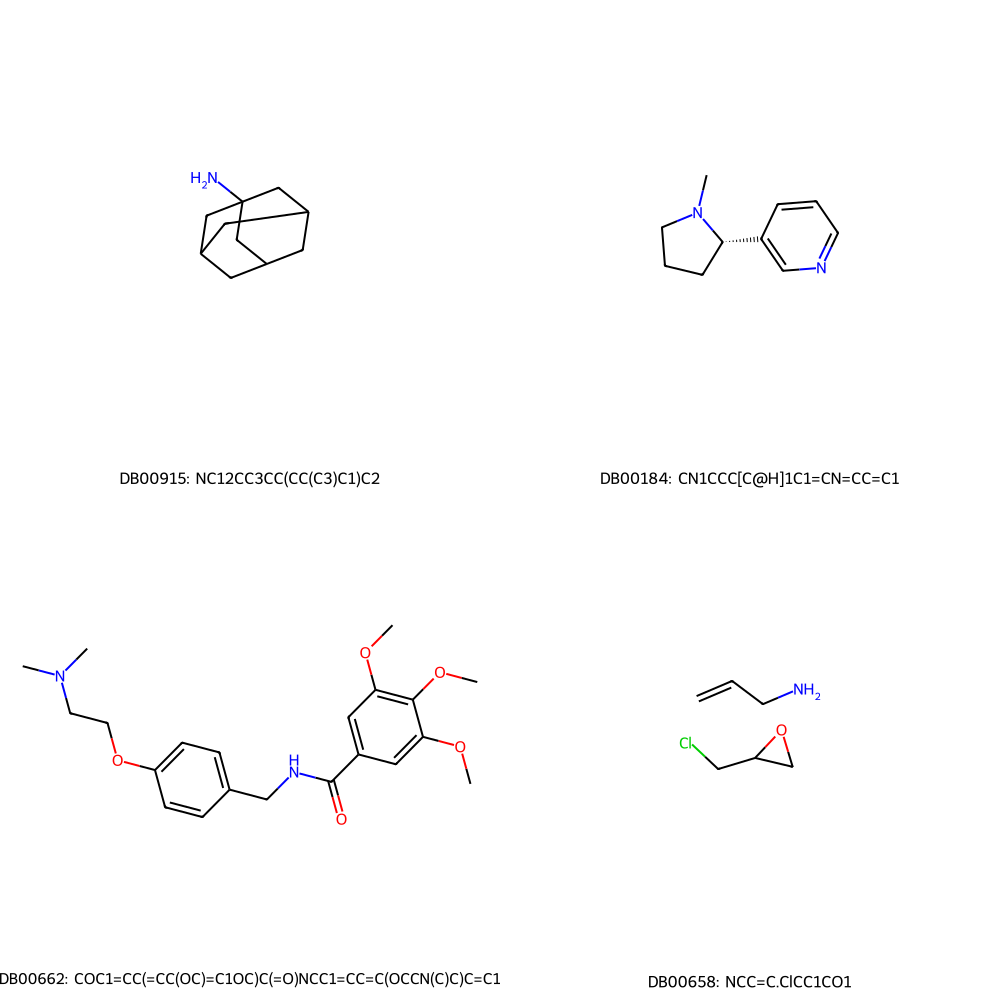

In [272]:
## Visualize 2D Representations of 4 Randomly selected modelcules
idxs = np.random.randint(0, len(drugbankddi_rds.rdkit_drug_mols)-1, 4)
mols    = [list(mol.values())[0]['mol'] for idx,mol in enumerate(drugbankddi_rds.rdkit_drug_mols)  if idx in idxs]
legends = [ list(mol.keys())[0] + ': ' + list(mol.values())[0]['smiles'] for idx,mol in enumerate(drugbankddi_rds.rdkit_drug_mols)  if idx in idxs]
smiles  = [ list(mol.values())[0]['smiles'] for idx,mol in enumerate(drugbankddi_rds.rdkit_drug_mols)  if idx in idxs]
drugbankddi_rds.draw_rdkit_im(mols, legends , molsPerRow=2,  subImgSize= (500,500) )

In [273]:
## For Rotatable 3D Structures of the same molecules
drugbankddi_rds.view_in_3D(smiles)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

#Context:

These are one hot encoded vectors of contexts provided  from the Data source. They are essentially a label for the context.

**Examining Context and Features for DrugBankDDI**

See the data source at https://bitbucket.org/kaistsystemsbiology/deepddi/src/master/data/DrugBank_known_ddi.txt

Context Information: https://bitbucket.org/kaistsystemsbiology/deepddi/src/master/data/Interaction_information.csv

DrugBankDDI Data Source: https://www.pnas.org/doi/10.1073/pnas.1803294115

In [274]:
drugbankddi_ctx = drugbankddi_rds.get_context_features()
drugbankddi_ctx ['context_01']

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [275]:
drugbankddi_ctx ['context_02']

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

To get an idea of the Contexts used for DrugBankDDI,  load the Interaction_Contexts.csv file. A copy is also available here https://bitbucket.org/kaistsystemsbiology/deepddi/src/master/data/Interaction_information.csv. Simply copy  or download it into a file and rename it.

In [276]:
contexts_df = pd.read_csv("/content/Interaction_Contexts.csv")

In [277]:
contexts_df.head()

,Interaction type,Description,Subject,DDI type
0,1,#Drug1 may increase the photosensitizing activ...,1,DDI type 75
1,2,#Drug1 may increase the anticholinergic activi...,2,DDI type 45
2,3,The bioavailability of #Drug2 can be decreased...,1,DDI type 4
3,4,The metabolism of #Drug2 can be increased when...,1,DDI type 7
4,5,#Drug1 may decrease the vasoconstricting activ...,1,DDI type 42


The context here represents  1 of 86 interaction types. It is a one hot encoded vector for each context. For example context_1 has value 1.0 at position [0], otherwise 0.0, context_2 has 1.0 and position [1] otherwise 0 , and so on. The source data can be founs at can be found at https://bitbucket.org/kaistsystemsbiology/deepddi/src/master/data/Interaction_information.csv .



**Examining Context and Features for DrugCombDB**

The identifiers/keys for the context in this dataset can be seen below. See more details at http://drugcombdb.denglab.org

In [278]:
drugcombdb_rds = CustomRtDatasetLoader("drugcombdb")
drubcombdb_drug_features =drugcombdb_rds.get_drug_features()

In [279]:
drugcombdb_ctx = drugcombdb_rds.get_context_features()

In [280]:
## This is list of contexts from Drugcombdb
print(list(drugcombdb_ctx.keys()))

['RXF 393', 'HS 578T', 'SK-MEL-5', 'UO-31', 'UWB1289', 'T-47D', 'MDAMB436', 'U-HO1', 'UACC-257', 'SK-OV-3', 'HCT-15', 'JHH-520', 'ES2', 'EW-8', 'MALME-3M', 'LOVO', 'NCIH1650', 'MDA-MB-435', 'SK-MEL-28', 'PC-3', 'UWB1289+BRCA1', 'JHH-136', 'NCI-H226', 'COLO 205', 'VCAP', 'PA1', 'MDA-MB-468', 'TMD8', 'HOP-62', 'A375', 'RD', 'DU-145', '786-0', 'OVCAR-8', 'OVCAR-5', 'SF-539', 'SW-620', 'K-562', 'KM12', 'IGROV1', 'ZR751', 'RPMI-8226', 'SK-MEL-2', 'KBM-7', 'L-1236', 'OVCAR3', 'NCI-H322M', 'NCI-H522', 'U251', 'KPL1', 'HOP-92', 'NCI-ADR-RES', 'MDA-MB-231', 'SF-268', 'TK-10', 'A2058', 'MOLT-4', 'CAKI-1', 'CAOV3', 'OV90', '3D7', 'MCF7', 'SR', 'HCC-2998', 'T98G', 'DD2', 'HDLM-2', 'Rh36', 'OVCAR-4', 'RPMI7951', 'HCT116', 'NCIH520', 'LOX IMVI', 'CCRF-CEM', 'CTR', 'SF-295', 'EFM192B', 'SKMEL30', 'HT29', 'A549', 'EKVX', 'COLO320DM', 'DIPG25', 'A-673', 'HT144', 'M14', 'TC-32', 'SW837', 'MSTO', 'BT-549', 'SU-DIPG-XIII', 'RKO', 'SKMES1', 'A2780', 'NCI-H460', 'NCIH23', 'NCIH2122', 'TC-71', 'SNB-19', 'A42

##Labeled Triples:

These include the Identifiers of the two drugs to be compared, the id for the context, and the label. For DrugBankDDI a label on 1.0 indicates a known interaction, ***while 0.0 may indicate no interaction or unkown***. The data is held in a pandas DataFrame. These are essentially the input labels. This demonstration will focus on DrugBankDDI for most of this data loading demonstration, then switches to DeepCombDB for training.

In [281]:
labeled_triples_drugbank_ddi = drugbankddi_rds.get_labeled_triples()
##View the labelled Triples
labeled_triples_drugbank_ddi.data

,drug_1,drug_2,context,label
0,DB04571,DB00460,context_01,1.0
1,DB00855,DB00460,context_01,1.0
2,DB09536,DB00460,context_01,1.0
3,DB01600,DB00460,context_01,1.0
4,DB09000,DB00460,context_01,1.0
...,...,...,...,...
383611,DB06335,DB06706,context_02,0.0
383612,DB00946,DB00575,context_60,0.0
383613,DB01081,DB04576,context_25,0.0
383614,DB01463,DB08899,context_29,0.0


#Examining some values with known interactions of a given context.


In [282]:
context_id = "context_30"
context_id_int = int(context_id.replace("context_", ""))
for descr in contexts_df["Description"][contexts_df["Interaction type"]== context_id_int].values:
  print(context_id , " - ", descr)

context_30  -  #Drug1 may increase the orthostatic hypotensive activities of #Drug2.


**View some known interaction labelled triples for the context**

In [283]:
filter = (labeled_triples_drugbank_ddi.data["context"] == context_id) & (labeled_triples_drugbank_ddi.data["label"]==1.0)
labeled_triples_drugbank_ddi.data[filter]

,drug_1,drug_2,context,label
28072,DB00960,DB00457,context_30,1.0
28073,DB01297,DB00457,context_30,1.0
28074,DB01351,DB00999,context_30,1.0
28075,DB01154,DB00436,context_30,1.0
28076,DB00571,DB00598,context_30,1.0
...,...,...,...,...
28683,DB04846,DB00598,context_30,1.0
28684,DB00489,DB00476,context_30,1.0
28685,DB01136,DB00457,context_30,1.0
28686,DB01580,DB01162,context_30,1.0


To validate the Interaction Data, the Interaction Checker at https://dev.drugbank.com/demo/ddi_checker can be used. As an example,
Pindolol - DB00960 and
Prazosin - DB00457 from the labelled triples were used.

<img src="https://drive.google.com/uc?export=view&id=1qZIB9C6U3ITJmo4O2rqNqt6c2s67PxRQ" />

As the image shows, the interaction context matches the description of context_30 above.



# Othe Datasets , Brief Example

To get an idea of how to access data for the other datasets, here is a brief example of the DrugCombDB dataset Labelled Triples. The structure of the very similar to DrugBankDDI.

In [284]:
labeled_triples_drugcombdb = drugcombdb_rds.get_labeled_triples()
labeled_triples_drugcombdb.data

,drug_1,drug_2,context,label
0,3385,11960529,A2058,1.0
1,3385,24856436,A2058,1.0
2,3385,11977753,A2058,1.0
3,3385,387447,A2058,0.0
4,3385,3062316,A2058,1.0
...,...,...,...,...
191386,46918825,11598628,A-673,1.0
191387,68210102,11598628,A-673,0.0
191388,5281607,11598628,A-673,0.0
191389,515328,16654980,U-HO1,1.0


# Loading Custom Data

In [285]:
os.chdir("/usr/local/lib/python3.10/dist-packages/chemicalx/data")

 **Example: Adding new drugs from DrugBank:**

The Drugs Nirogacestat, with brand name Ogsiveo was approved by the Food and Drug Administration (FDA) in November 2023. It is not in the list we downloaded from the ChemicalX repository because it is a static file that has not been updated since 2022.  We will attempt to preprocess and load it locally.

This example uses a context and interaction data found on DrugBank.com. The DrugBank Accession Number is of Nirogacestat/Ogsiveo is DB12005.

DrugBank.com shows that when
Aluminum hydroxide - DB06723 interacts with Nirogacestat is DB12005, ***the serum concentration of Nirogacestat can be decreased when it is combined with Aluminum hydroxide.*** This corresponds with context_73 in the contexts dataset and Aluminum hydroxide - DB06723 already exists in teh dataset.

*&nbsp;<b>Important:</b> This test is not to be taken as fact. It is merely an example of data preparation and explorartion for ChemicalX Drug-Drug Interaction deep learning. Please consult a medical or pharmaceutical professional for drug-drug interaction related questions*

In [286]:
##Viweing the context chosen
contexts_df[contexts_df["Interaction type"] == 73]

for x in contexts_df["Description"][contexts_df["Interaction type"] == 73].values:
  print(x)

The serum concentration of #Drug2 can be increased when it is combined with #Drug1.


In [287]:
## Features for Aluminum hydroxide - DB06723
remote_drug_features["DB06723"]

{'features': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    

In [288]:
##
## These are hardcoded smiles but can be accessed through an API.
## The API requires manual Approval from DrugBank Online and is also a commercial, paid product.
## However, for this quick example, the smiles and Drug Accession Number were copied and pasted

## Adding Nirogacestat/Ogsiveo to featureset
DrugBank_Accession_Number = "DB12005"
smiles = "CCC[C@H](N[C@H]1CCC2=CC(F)=CC(F)=C2C1)C(=O)NC1=CN(C=N1)C(C)(C)CNCC(C)(C)C"
try:
  ##Checking if record exists in the dataset
  x = remote_drug_features[DrugBank_Accession_Number]

except KeyError:
  print(f'{DrugBank_Accession_Number} not found, preparing data...')
  features = drugbankddi_rds.get_morgan_fingerprints(smiles, radius=2, nBits=256)
  ##Torchdrug's Molecule Class is used to genetate a molecular graph
  remote_drug_features[DrugBank_Accession_Number] = {"features" : features , "molecule": Molecule.from_smiles(smiles)}


DB12005 not found, preparing data...


In [289]:
##The newly created Feature
remote_drug_features["DB12005"]

{'features': tensor([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         1, 0, 1, 1, 0, 0, 0, 0, 1, 7, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
         1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 1, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
         0, 0, 1, 0, 5, 1, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 1, 1, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 7, 0, 2, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 1, 0, 0, 2,
         0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
         0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1], dtype=torch.int8),
 'molecule': Molecule(num_atom=35, num_bond=74)}

##Adding New data to Labelled Triples

- This can accomplished by appending the new row(s) to the labelled triples dataset.

In [290]:
##get the columns from the existing dataset
columns = labeled_triples_drugbank_ddi.data.columns
columns

Index(['drug_1', 'drug_2', 'context', 'label'], dtype='object')

In [291]:
## this adds the new_data using the known context and interaction label into the dataset
new_context = "context_73"
new_ddi_df  = pd.DataFrame(data= [["DB06723","DB12005", new_context, 1.0]], columns = labeled_triples_drugbank_ddi.data.columns,  )

In [292]:
new_ddi_df

,drug_1,drug_2,context,label
0,DB06723,DB12005,context_73,1.0


In [293]:
new_ddi_df

,drug_1,drug_2,context,label
0,DB06723,DB12005,context_73,1.0


In [294]:
#append to the end of the existing data
pd.concat([labeled_triples_drugbank_ddi.data, new_ddi_df], axis = 0, ignore_index=True)

,drug_1,drug_2,context,label
0,DB04571,DB00460,context_01,1.0
1,DB00855,DB00460,context_01,1.0
2,DB09536,DB00460,context_01,1.0
3,DB01600,DB00460,context_01,1.0
4,DB09000,DB00460,context_01,1.0
...,...,...,...,...
383612,DB00946,DB00575,context_60,0.0
383613,DB01081,DB04576,context_25,0.0
383614,DB01463,DB08899,context_29,0.0
383615,DB00213,DB01489,context_17,0.0


In [295]:
##original
labeled_triples_drugbank_ddi.data.tail()

,drug_1,drug_2,context,label
383611,DB06335,DB06706,context_02,0.0
383612,DB00946,DB00575,context_60,0.0
383613,DB01081,DB04576,context_25,0.0
383614,DB01463,DB08899,context_29,0.0
383615,DB00213,DB01489,context_17,0.0


In [296]:
## After confirming indexing  recreate the data
labeled_triples_drugbank_ddi.data = pd.concat([labeled_triples_drugbank_ddi.data, new_ddi_df], axis = 0, ignore_index=True)


In [297]:
## this confirms that the new data has been added.
labeled_triples_drugbank_ddi.data.tail()

,drug_1,drug_2,context,label
383612,DB00946,DB00575,context_60,0.0
383613,DB01081,DB04576,context_25,0.0
383614,DB01463,DB08899,context_29,0.0
383615,DB00213,DB01489,context_17,0.0
383616,DB06723,DB12005,context_73,1.0


# Loading Custom Data
In this example, we will use the custom dataset with the new features and labels added.

In [298]:
from chemicalx import pipeline
from chemicalx.models import DeepSynergy
from chemicalx.data import DrugbankDDI

## To load data using the provided utilities use the datasets's Class
loader = DrugbankDDI()
default_context_set = loader.get_context_features()
default_drug_set = loader.get_drug_features()
default_triples = loader.get_labeled_triples()


In [299]:
## confirming that the new drug set has the new data
print( "original data count: ", len(list(default_drug_set.keys())))
print( "new data count :" , len(list(remote_drug_features.keys())))
conf = "exists" if not default_drug_set.get(DrugBank_Accession_Number) is None else "does not exist"
print( f"The new drug {DrugBank_Accession_Number} {conf} in the default_drug_set.")
conf = "exists" if not remote_drug_features.get(DrugBank_Accession_Number) is None else "does not exist"
print( f"The new drug {DrugBank_Accession_Number} {conf} in the new data set.")

original data count:  1706
new data count : 1707
The new drug DB12005 does not exist in the default_drug_set.
The new drug DB12005 exists in the new data set.


In [300]:
##examining the default dataset it does not contain the new data
default_drug_set.get("DB12005") is None


True

#Training a Model:
ChemicalX uses Geometric Deep Learning, Deep Chemistry layers and many other utiliies available in Pytorch.The models provided can perform drug-pair scoring tasks on datasets with hundreds of thoudands of compounds, all on widely available hardware.

The Deep Synergy Model will used for  Drug Pair Synergy and has been evaluated in the ChemicalX paper with a AUROC score of 0.744 on **DrugComb**. This demonstration will train a model on using the **DrugCombDB data**, while using the data loaded using the custom data loader class. This allows some flexibility for users to add new data in the same way the data was added into the DrugBankDDI  dataset.


In [301]:
##create instance of Custom Dataset Loader
drugcombdb_rds = CustomRtDatasetLoader("drugcombdb")

In [302]:
#this function can be used to add new data
def add_new_features(drug_features , new_id, smiles,  loader : CustomRtDatasetLoader):
    print(f'{new_id} not found, preparing data...')
    features = loader.get_morgan_fingerprints(smiles, radius=2, nBits=256)
    ##Torchdrug's Molecule Class is used to genetate a molecular graph
    drug_features[new_id] = {"features" : features , "molecule": Molecule.from_smiles(smiles)}
    return drug_features




In [303]:
## For this hypothetical example , a feature for SUCROSE
## will be created for the DrugCombDB dataset

smiles = "C(C1C(C(C(C(O1)OC2(C(C(C(O2)CO)O)O)CO)O)O)O)O"
test_features =drugcombdb_rds.get_drug_features()
new_test_features = add_new_features(drug_features =test_features ,
                                     new_id  = '99999999',
                                     smiles  = smiles,
                                     loader  = drugcombdb_rds)

99999999 not found, preparing data...


In [304]:
## checking the new data
new_test_features['99999999']

{'features': tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 8, 0, 0, 0, 1, 0, 0, 1, 0,
         0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 1, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 6, 0, 0, 2, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 8, 0, 0, 0, 0], dtype=torch.int8),
 'molecule': Molecule(num_atom=23, num_bond=48)}

In [305]:
##Once the features are added, the additional feature must be added to the labelled Triples as shown in
## the DrugBankDDI Example.
##Clean up
del new_test_features
del test_features



# Loading Data and Model Training:

In [306]:
drubcombdb_drug_features          =drugcombdb_rds.get_drug_features()
drugcombdb_ctx                    =drugcombdb_rds.get_context_features()
drugcombdb_labeled_triples        =drugcombdb_rds.get_labeled_triples()

In [307]:
## examine labels

drugcombdb_labeled_triples.data.head()

,drug_1,drug_2,context,label
0,3385,11960529,A2058,1.0
1,3385,24856436,A2058,1.0
2,3385,11977753,A2058,1.0
3,3385,387447,A2058,0.0
4,3385,3062316,A2058,1.0


## Checking for Class Imbalance
Since this is Binary Classification, checking and rectifying the data for imbalance can improve the model's performance.

In [308]:
## check for imbalance in the dataset labels
negatives = drugcombdb_labeled_triples.get_negative_rate()
negatives

0.7067416963180086

The dataset is Skewed towards the negative class, a common issue in many binary classification problems.  There are many methods to rectify this including over and undersampling. Howeever,  in this demontration, we will run this as it is to showcase the library

In [309]:
from chemicalx.data import  BatchGenerator


##Loading the data
context_set = drugcombdb_ctx
drug_set    = drubcombdb_drug_features
triples     = drugcombdb_labeled_triples

train, test = triples.train_test_split(train_size=0.6,random_state=1024)

batch_size = 1024
## Elect to include molecules in the training. This will result in more training time.
molecules  = False

train_generator = BatchGenerator(batch_size=batch_size,
                                 context_features=True,
                                 drug_features=True,
                                 drug_molecules=molecules,
                                 context_feature_set=context_set,
                                 drug_feature_set=drug_set,
                                 labeled_triples=train)


valid_generator = BatchGenerator(batch_size=batch_size,
                                 context_features=True,
                                 drug_features=True,
                                 drug_molecules=molecules,
                                 context_feature_set=context_set,
                                 drug_feature_set=drug_set,
                                 labeled_triples=test)




In [310]:
from chemicalx.models import DeepSynergy

model = DeepSynergy(context_channels=112,
                    drug_channels=256)

torch.cuda.manual_seed(23)
torch.manual_seed(23)
epochs = 20
optimizer = torch.optim.Adam(model.parameters())
loss = torch.nn.BCELoss()

def train():

    training_losses = []
    valid_losses    = []
    for epoch in range(epochs):
        train_batch_counter = 0
        train_loss_sum      = 0

        valid_batch_counter = 0
        valid_loss_sum       = 0
        model.train()
        for batch in train_generator:
            optimizer.zero_grad()
            prediction = model(batch.context_features,
                               batch.drug_features_left,
                               batch.drug_features_right)
            loss_value = loss(prediction, batch.labels)
            loss_value.backward()
            optimizer.step()
            train_loss_sum+= loss_value.item()
            train_batch_counter += 1

        model.eval()
        for vbatch in valid_generator:
            prediction = model(vbatch.context_features,
                              vbatch.drug_features_left,
                              vbatch.drug_features_right)
            valid_loss_value = loss(prediction, vbatch.labels)
            valid_loss_sum+= valid_loss_value.item()
            valid_batch_counter += 1

        train_epoch_loss = train_loss_sum/train_batch_counter
        valid_epoch_loss = valid_loss_sum/valid_batch_counter

        print("Epoch Loss: {a:4d} | Train Loss: {b:4.8f},  Valid Loss: {c:4.8f}".
         format(a = epoch + 1, b = train_epoch_loss, c=valid_epoch_loss))
        training_losses.append(train_epoch_loss)
        valid_losses.append(valid_epoch_loss)

    return training_losses, valid_losses





In [311]:
train_losses, valid_losses = train()

Epoch Loss:    1 | Train Loss: 0.60897569,  Valid Loss: 0.55137952
Epoch Loss:    2 | Train Loss: 0.54278139,  Valid Loss: 0.51404749
Epoch Loss:    3 | Train Loss: 0.52013581,  Valid Loss: 0.49648814
Epoch Loss:    4 | Train Loss: 0.50459018,  Valid Loss: 0.48919316
Epoch Loss:    5 | Train Loss: 0.49230121,  Valid Loss: 0.47796681
Epoch Loss:    6 | Train Loss: 0.48239184,  Valid Loss: 0.47059734
Epoch Loss:    7 | Train Loss: 0.47509098,  Valid Loss: 0.46832458
Epoch Loss:    8 | Train Loss: 0.46833107,  Valid Loss: 0.46196302
Epoch Loss:    9 | Train Loss: 0.46313739,  Valid Loss: 0.46221304
Epoch Loss:   10 | Train Loss: 0.45692550,  Valid Loss: 0.45756936
Epoch Loss:   11 | Train Loss: 0.45160544,  Valid Loss: 0.45946735
Epoch Loss:   12 | Train Loss: 0.44811606,  Valid Loss: 0.45349672
Epoch Loss:   13 | Train Loss: 0.44337696,  Valid Loss: 0.45348209
Epoch Loss:   14 | Train Loss: 0.44052937,  Valid Loss: 0.45334847
Epoch Loss:   15 | Train Loss: 0.43763298,  Valid Loss: 0.4527

#Links to YouTube Videos:

**Intro: https://youtu.be/x7ii7IJ-1MU**

**Full : https://youtu.be/XihDBVrsj4A**


#References

Using grep to replace a string: https://stackoverflow.com/questions/15402770/how-to-search-and-replace-using-grep

Find and replace text within a file using commands:  https://askubuntu.com/questions/20414/find-and-replace-text-within-a-file-using-commands

Visualizing molecules built from SMILES strings in Jupyter Notebooks using molSimplify: https://hjkgrp.mit.edu/tutorials/2021-11-03-visualizing-molecules-built-smiles-strings-jupyter-notebooks-using-molsimplify/

Hashed Morgan Fingerprint To Numpy Array: https://stackoverflow.com/questions/54809506/how-can-i-compute-a-count-morgan-fingerprint-as-numpy-array

